In [36]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from typing import Tuple

In [37]:
class Square:

    def __init__(self, upper_left_corner_coords: Tuple[int, int], cropped_image_stack: np.ndarray) -> None:
        self.upper_left_corner_coords = upper_left_corner_coords
        self.image_stack = cropped_image_stack
        self.center_coords = self._get_center_coords()


    def compute_mean_intensity_timeseries(self) -> None:
        self.intensities = np.mean(self.image_stack, axis = (1,2))


    def detect_peaks(self, signal_to_noise_ratio: float) -> None:
        self.frame_idxs_of_peaks = signal.find_peaks_cwt(vector = self.intensities, wavelet = signal.ricker, widths = np.arange(1, 81), min_length = 7, noise_perc = 10, min_snr = signal_to_noise_ratio)
        self.peaks_count = self.frame_idxs_of_peaks.shape[0]


    def plot_intensity_trace_with_identified_peaks(self) -> None:
        self.plotted_trace = plt.figure(figsize = (12, 3), facecolor = 'white')
        self.plotted_trace = plt.plot(intensities, zorder = 0, c='black')
        self.plotted_trace = plt.scatter(x = frame_idxs_of_peaks, y = intensities[frame_idxs_of_peaks], color = 'red')
        self.plotted_trace = plt.ylabel('mean bit value')
        self.plotted_trace = plt.xlabel('frame index')
        self.plotted_trace = plt.title(f'Graph "x-idx", "y-idx"    Total Activity: {frame_idxs_of_peaks.shape[0]}')
        self.plotted_trace = plt.tight_layout()


    def _get_center_coords(self) -> Tuple[int, int]:
        square_height = self.image_stack.shape[1]
        square_width = self.image_stack.shape[2]
        return (self.upper_left_corner_coords[0] + int(square_height/2), self.upper_left_corner_coords[1] + int(square_width/2))

In [38]:
video_filepath = 'spiking_neuron.avi'
signal_to_noise_ratio = 10
window_size = 8

In [39]:
frames = iio.imread(video_filepath)
gray_scale_frames = frames[:, :, :, 0].copy()


grid_rows = np.arange(start = 0, stop = gray_scale_frames.shape[1], step = window_size)
grid_cols = np.arange(start = 0, stop = gray_scale_frames.shape[2], step = window_size)

square_upper_left_coords = []

for row in grid_rows:
    for col in grid_cols:
        square_upper_left_coords.append((row, col))


all_squares = []
for upper_left_y, upper_left_x in square_upper_left_coords:
    square_y_coords_slice = slice(upper_left_y, upper_left_y + window_size)
    square_x_coords_slice = slice(upper_left_x, upper_left_x + window_size)
    selected_square = gray_scale_frames[:, square_y_coords_slice, square_x_coords_slice]
    all_squares.append(Square(upper_left_corner_coords = (upper_left_y, upper_left_x), cropped_image_stack = selected_square))

for square in all_squares:
    square.compute_mean_intensity_timeseries()
    square.detect_peaks(signal_to_noise_ratio = signal_to_noise_ratio)

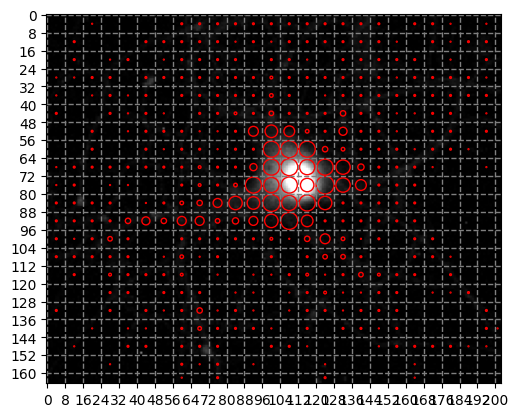

In [40]:
from matplotlib.ticker import MultipleLocator


# calculating the coordinates
# x_coords = [i for i in range(int(window_size/2), gray_scale_frames.shape[2], window_size)]
# y_coords = [i for i in range(int(window_size/2), gray_scale_frames.shape[1], window_size)]
# coords = [(x,y) for x in x_coords for y in y_coords]

# creating the list of random sizes
# sizes = np.random.random_integers(0,100,len(coords))
sizes = [square.peaks_count for square in all_squares]
# creating the plot
fig, ax = plt.subplots()
# drawing the circles
for square in all_squares:
    true_size = (square.peaks_count/max(sizes))*(window_size/2)
    circle = plt.Circle((square.center_coords[1], square.center_coords[0]), radius=true_size, fill=False, color='red')
    ax.add_patch(circle)

# putting the image in the background
background = gray_scale_frames[0]
ax.imshow(gray_scale_frames[0], cmap="gray")

# putting the grid on top of the image
ax.grid(color = 'gray', linestyle = '--', linewidth = 1)

# setting the grid size to the square size
ax.xaxis.set_major_locator(MultipleLocator(window_size))
ax.yaxis.set_major_locator(MultipleLocator(window_size))